In [ ]:
# check against table 7

In [1]:
import os
import cantera as ct
import numpy as np
import pandas as pd
import concurrent.futures


import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# # Load the model

cti_path = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/cutoff3_20230501-2.cti'
cti_path = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/cutoff3_20230502.cti'
cti_path = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/cutoff3_20230505_all.cti'
cti_path = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/cutoff3_20230505_top50.cti'
cti_path = '/work/westgroup/harris.se/autoscience/reaction_calculator/models/base_rmg_1week/cutoff3_20230511_top50.cti'

cti_path = '/work/westgroup/harris.se/autoscience/fuels/butane/small_lib_20230801/chem_annotated.cti'

cti_path = '/work/westgroup/harris.se/autoscience/fuels/butane/small_lib_20230801/change288.cti'
cti_path = '/work/westgroup/harris.se/autoscience/fuels/butane/small_lib_20230801/chem_annotated.cti'

gas = ct.Solution(cti_path)

In [16]:
# Load the experimental conditions
ignition_delay_data = '/work/westgroup/harris.se/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * ct.one_atm  # pressures in atm


# list of starting conditions
# Mixture compositions taken from table 2 of
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
concentrations = []
# for phi = 1
x_diluent = 0.7649
conc_dict = {
    'O2(2)': 0.2038,
    'butane(1)': 0.03135
}

for i in range(0, len(table7)):
    x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
    x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
    x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
    conc_dict['N2'] = x_N2
    conc_dict['Ar'] = x_Ar
    conc_dict['CO2(7)'] = x_CO2
    concentrations.append(conc_dict)

    
# # Aramco naming:
# x_diluent = 0.7649
# conc_dict = {
#     'O2': 0.2038,
#     'C4H10': 0.03135
# }

# for i in range(0, len(table7)):
#     x_N2 = table7['%N2'].values[i] / 100.0 * x_diluent
#     x_Ar = table7['%Ar'].values[i] / 100.0 * x_diluent
#     x_CO2 = table7['%CO2'].values[i] / 100.0 * x_diluent
#     conc_dict['N2'] = x_N2
#     conc_dict['AR'] = x_Ar
#     conc_dict['CO2'] = x_CO2
#     concentrations.append(conc_dict)


In [17]:
# Take Reactor Conditions from Table 7 of supplementary info in
# https://doi-org.ezproxy.neu.edu/10.1016/j.combustflame.2010.01.016
def get_delay(gas, T, P, X):
    # function to run a RCM simulation

    t_end = 1.0  # time in seconds
    gas.TPX = T, P, X

    env = ct.Reservoir(ct.Solution('air.yaml'))
    # env = ct.Reservoir(ct.Solution('air.xml'))
    reactor = ct.IdealGasReactor(gas)
    wall = ct.Wall(reactor, env, A=1.0, velocity=0)
    reactor_net = ct.ReactorNet([reactor])
    # # allegedly faster solving
    # reactor_net.derivative_settings = {"skip-third-bodies": True, "skip-falloff": True}
    # reactor_net.preconditioner = ct.AdaptivePreconditioner()

    times = [0]
    T = [reactor.T]
    P = [reactor.thermo.P]
    X = [reactor.thermo.X]  # mol fractions
    while reactor_net.time < t_end:
        reactor_net.step()

        times.append(reactor_net.time)
        T.append(reactor.T)
        P.append(reactor.thermo.P)
        X.append(reactor.thermo.X)

    slopes = np.gradient(P, times)
    i = np.argmax(slopes)
    return times[i]

In [18]:
def run_simulation(condition_index):
    gas = ct.Solution(cti_path)
    X = concentrations[condition_index]
    delay = get_delay(gas, T7[condition_index], P7[condition_index], X)
    print(f'Completed {condition_index}:\t {delay}')
    return delay

In [19]:
# Run all simulations in parallel
delays = np.zeros(len(table7))
condition_indices = np.arange(0, len(table7))
with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:
    for condition_index, delay_time in zip(condition_indices, executor.map(run_simulation, condition_indices)):
        delays[condition_index] = delay_time

Completed 15:	 0.012313291929806923
Completed 13:	 0.01487131859936374
Completed 14:	 0.014706786604967312
Completed 12:	 0.015241844081943394
Completed 11:	 0.013098654561596828Completed 10:	 0.011697978265131708

Completed 8:	 0.007220882706883617
Completed 9:	 0.008247118799546557
Completed 6:	 0.0043353529934715895
Completed 7:	 0.004363574007978711
Completed 5:	 0.0043255174095131075
Completed 4:	 0.004358240737185915
Completed 2:	 0.005814515617340822
Completed 3:	 0.0057246403755111365
Completed 0:	 0.010798175690852686
Completed 1:	 0.010546502326832382


In [20]:
delays

array([0.01079818, 0.0105465 , 0.00581452, 0.00572464, 0.00435824,
       0.00432552, 0.00433535, 0.00436357, 0.00722088, 0.00824712,
       0.01169798, 0.01309865, 0.01524184, 0.01487132, 0.01470679,
       0.01231329])

In [21]:
# Saved ignition delays for comparison:
change288 = np.array([0.01058585, 0.01033451, 0.00558142, 0.00549039, 0.00405637,
       0.00402012, 0.00380906, 0.00382908, 0.00618984, 0.00709061,
       0.01030155, 0.01173058, 0.01427357, 0.01422338, 0.01409682,
       0.0119558 ])
base_rmg7_24 = np.array([0.04908328, 0.04854439, 0.04814446, 0.04868176, 0.075588  ,
       0.07737167, 0.14791668, 0.14857535, 0.1085917 , 0.0952434 ,
       0.06520823, 0.05563237, 0.03535775, 0.02462961, 0.02334903,
       0.01398333])  # 24 hour RMG run - 110 species

full_base_rmg7 = np.array([0.04830086, 0.04773837, 0.0462931 , 0.04678523, 0.07270171,
       0.07446053, 0.14525752, 0.14593983, 0.10720529, 0.09406754,
       0.0644564 , 0.05500488, 0.03497752, 0.02436985, 0.02310303,
       0.01383285])  # 1 week RMG model that completed - all 130 species

aramco7 = np.array([0.03945921, 0.03874611, 0.02817182, 0.02812066, 0.03236667,
       0.03278732, 0.06009581, 0.06085926, 0.06020536, 0.05459522,
       0.03965133, 0.03435827, 0.02245863, 0.01580939, 0.01499945,
       0.00896072])
experiment7 = np.array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])


just_thermo = np.array([0.05437566, 0.05363216, 0.0468658 , 0.04713463, 0.06409101,
       0.06526021, 0.12212126, 0.1232444 , 0.1033291 , 0.09161158,
       0.06377597, 0.05461719, 0.03492282, 0.02437458, 0.02311091,
       0.01384534])

In [22]:
# read in the three datasets
i = 7
working_dir = '/work/westgroup/harris.se/autoscience/reaction_calculator/delay_uncertainty/'
base_rmg_delay_npy = os.path.join(working_dir, 'base_rmg_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
base_rmg_delay = np.load(base_rmg_delay_npy)

improved_rmg_delay_npy = os.path.join(working_dir, 'improved_1week', f'table_{i:04}', f'base_delays_{i:04}.npy')
improved_rmg_delay = np.load(improved_rmg_delay_npy)

aramco_delay_npy = os.path.join(working_dir, 'aramco', f'table_{i:04}', f'base_delays_{i:04}.npy')
aramco_delay = np.load(aramco_delay_npy)

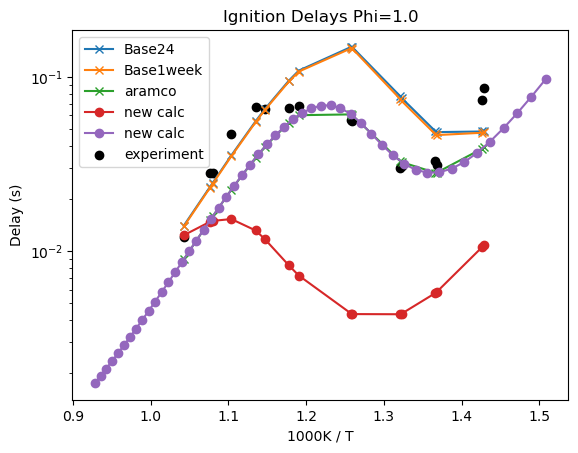

In [23]:
# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7_24, marker='x', label='Base24')
plt.plot(1000.0 / T7, full_base_rmg7, marker='x', label='Base1week')

plt.plot(1000.0 / T7, aramco7, marker='x', label='aramco')
plt.plot(1000.0 / T7, delays, marker='o', label='new calc')

plt.plot(1000.0 / np.linspace(663, 1077, 51), aramco_delay, marker='o', label='new calc')

plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')
ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

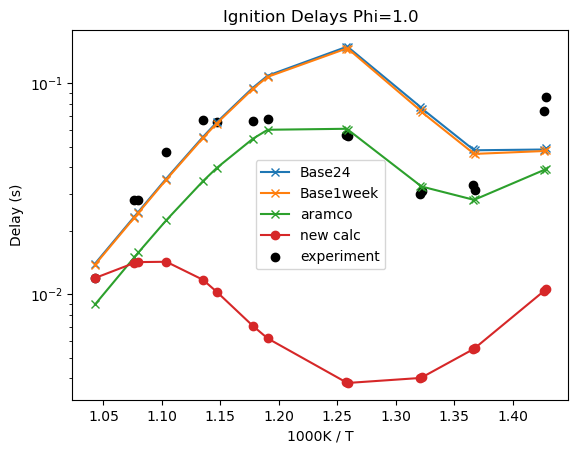

In [11]:
# plot the ignition delay
plt.plot(1000.0 / T7, base_rmg7_24, marker='x', label='Base24')
plt.plot(1000.0 / T7, full_base_rmg7, marker='x', label='Base1week')

plt.plot(1000.0 / T7, aramco7, marker='x', label='aramco')
plt.plot(1000.0 / T7, delays, marker='o', label='new calc')


plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black', label='experiment')
ax = plt.gca()
ax.set_yscale('log')
plt.legend()
# plt.legend(['Mechanism 174', 'Base RMG', 'Aramco', 'Experiment'])
# plt.legend(['RMG 24', 'RMG 1 week', 'Aramco', 'new calculation', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [12]:
tau7 / 1000.0

array([0.0865 , 0.0739 , 0.0313 , 0.033  , 0.0309 , 0.03   , 0.056  ,
       0.0566 , 0.0679 , 0.0664 , 0.0652 , 0.0671 , 0.047  , 0.0279 ,
       0.02805, 0.012  ])

In [13]:
1000.0 / T7

array([1.42857143, 1.42653352, 1.36798906, 1.36612022, 1.32275132,
       1.32100396, 1.25944584, 1.25786164, 1.19047619, 1.1778563 ,
       1.14678899, 1.13507378, 1.10375276, 1.07991361, 1.07642626,
       1.04275287])

## Calculate Simple Linear Squared Error

In [ ]:
def get_error(points):
    return np.dot(points - experiment7, points - experiment7)

In [ ]:
print('Base RMG 24 Error:\t', get_error(base_rmg7_24))
print('Base RMG 1 week Error:\t', get_error(full_base_rmg7))
print('Aramco Error:\t', get_error(aramco7))



print('Just thermo Error:\t', get_error(just_thermo))
print('New Calc Error:\t', get_error(delays))

In [ ]:
# plot the ignition delay
# plt.plot(1000.0 / T7, delays, marker='x')
# plt.plot(1000.0 / T7, small_core_rmg, marker='x')
# plt.plot(1000.0 / T7, no_libraries, marker='x')
plt.plot(1000.0 / T7, base_rmg7, marker='x')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco [1]', 'Experiment [2]'])
plt.annotate('Base RMG', (1,1))
# plt.legend(['New Calculations', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)

In [ ]:
# plot the ignition delay
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(1000.0 / T7, base_rmg7, marker='x')
plt.plot(1000.0 / T7, aramco7, marker='x')
plt.plot(1000.0 / T7, delays, marker='x')
plt.plot(1000.0 / T7, refit_data, marker='x', color=colors[6])
plt.scatter(1000.0 / T7, tau7 / 1000.0, color='black')
ax = plt.gca()
ax.set_yscale('log')
plt.legend(['Base RMG', 'Aramco', 'New Calculations', 'Refit Tree', 'Experiment'])



# plt.annotate('Base RMG', (1.2, 0.2), color=colors[0], size=14)

# ax.annotate('Base RMG', xy=(1000.0 / T7[7], base_rmg7[7]),  xycoords='data',
#             xytext=(0.5, 0.2), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

# plt.legend(['New Calculations', 'Small Core RMG', 'No Libraries', 'Base RMG', 'Aramco', 'Experiment'], loc=(1.04, 0))
plt.title('Ignition Delays Phi=1.0')
plt.xlabel('1000K / T')
plt.ylabel('Delay (s)')
plt.savefig('table7.png')
# plt.legend(bbox_to_anchor=(0, 1), , ncol=1)